# 🌄 Landslide Detection Training - Attention U-Net


---

## 📋 Training Configuration

- **Model:** Attention U-Net (34M parameters)
- **Dataset:** 3,799 training images, 245 validation images
- **Loss:** Focal Loss + Tversky Loss (optimized for class imbalance)

---

## ⚠️ Important Notes

1. **Data Upload:** Upload `landslide_data.zip` (~2GB) when prompted
2. **Checkpoints:** Auto-saved every 5 epochs + best model
3. **Download:** Best model will be available for download at the end

---

# 📦 SECTION 1: Setup & Data Upload

In [3]:
# Load data from Google Drive
print("="*80)
print("📂 LOADING DATA FROM GOOGLE DRIVE")
print("="*80)

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your ZIP in Drive
zip_path = "/content/drive/MyDrive/landslide_data.zip"

# Verify file exists
if os.path.exists(zip_path):
    file_size = os.path.getsize(zip_path) / (1024**3)
    print(f"\n✓ Found landslide_data.zip in Drive!")
    print(f"  Size: {file_size:.2f} GB")
else:
    print("\n⚠️ ERROR: landslide_data.zip not found in Drive!")
    print("  Please upload to: My Drive/landslide_data.zip")

📂 LOADING DATA FROM GOOGLE DRIVE
Mounted at /content/drive

✓ Found landslide_data.zip in Drive!
  Size: 2.86 GB


In [14]:
# Extract data with Windows path fix
import zipfile
import os

print("\nExtracting data from Drive...")
zip_path = "/content/drive/MyDrive/landslide_data.zip"

# Create data directory first
os.makedirs('/content/data', exist_ok=True)

# Extract with Windows → Linux path conversion
print("Extracting with path fix...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
        # Convert Windows backslashes to Linux forward slashes
        fixed_path = member.replace("\\", "/")

        # Extract to /content/data/ instead of /content/
        target_path = os.path.join("/content/data", fixed_path)

        # Create directories if needed
        os.makedirs(os.path.dirname(target_path), exist_ok=True)

        # Extract file
        if not member.endswith('/'):  # Skip directories
            with zip_ref.open(member) as source, open(target_path, "wb") as target:
                target.write(source.read())

print("✓ Extraction complete!")

# Verify extracted structure
print("\nVerifying data structure...")
required_paths = [
    '/content/data/TrainData/img',
    '/content/data/TrainData/mask',
    '/content/data/ValidData/img',
    '/content/data/ValidData/mask',
    '/content/data/TestData/img',
    '/content/data/TestData/mask'
]

all_good = True
for path in required_paths:
    if os.path.exists(path):
        count = len([f for f in os.listdir(path) if f.endswith('.h5')])
        print(f"  ✓ {path}: {count} files")
    else:
        print(f"  ✗ {path}: NOT FOUND")
        all_good = False

if all_good:
    print("\n✅ All data verified! Ready to train!")
else:
    print("\n⚠️ ERROR: Some directories are missing!")


Extracting data from Drive...
Extracting with path fix...
✓ Extraction complete!

Verifying data structure...
  ✓ /content/data/TrainData/img: 3799 files
  ✓ /content/data/TrainData/mask: 3799 files
  ✓ /content/data/ValidData/img: 245 files
  ✓ /content/data/ValidData/mask: 245 files
  ✓ /content/data/TestData/img: 800 files
  ✓ /content/data/TestData/mask: 800 files

✅ All data verified! Ready to train!


In [15]:
# Create directories
!mkdir -p checkpoints
!mkdir -p results
print("✓ Directories created")

✓ Directories created


# 🧠 SECTION 2: Model & Training Code

These cells define the model architecture and training functions.

In [16]:
# 2.1 - Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [17]:
# 2.2 - Dataset class
class LandslideDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform

        if split == 'train':
            self.img_dir = os.path.join(data_dir, 'TrainData', 'img')
            self.mask_dir = os.path.join(data_dir, 'TrainData', 'mask')
        elif split == 'valid':
            self.img_dir = os.path.join(data_dir, 'ValidData', 'img')
            self.mask_dir = os.path.join(data_dir, 'ValidData', 'mask')
        else:
            self.img_dir = os.path.join(data_dir, 'TestData', 'img')
            self.mask_dir = os.path.join(data_dir, 'TestData', 'mask')

        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.h5')])
        print(f"Loaded {len(self.img_files)} images from {split} split")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        with h5py.File(img_path, 'r') as f:
            image = f['img'][:].astype(np.float32)

        # Normalize
        image = self.normalize_image(image)

        # Load mask
        mask_file = self.img_files[idx].replace('image', 'mask')
        mask_path = os.path.join(self.mask_dir, mask_file)
        with h5py.File(mask_path, 'r') as f:
            mask = f['mask'][:]

        # Apply augmentations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()
        else:
            mask = mask.long()

        return {'image': image, 'mask': mask, 'filename': self.img_files[idx]}

    def normalize_image(self, image):
        # Normalize each band
        for i in range(12):
            band = image[:, :, i]
            p2, p98 = np.percentile(band, (2, 98))
            band = np.clip(band, p2, p98)
            if p98 - p2 > 0:
                image[:, :, i] = (band - p2) / (p98 - p2)

        # Slope
        slope = image[:, :, 12]
        if slope.max() > slope.min():
            image[:, :, 12] = (slope - slope.min()) / (slope.max() - slope.min())

        # DEM
        dem = image[:, :, 13]
        if dem.max() > dem.min():
            image[:, :, 13] = (dem - dem.min()) / (dem.max() - dem.min())

        return image

print("✓ Dataset class defined")

✓ Dataset class defined


In [18]:
# 2.3 - Data augmentation
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Affine(
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            scale=(0.85, 1.15),
            rotate=(-45, 45),
            p=0.6
        ),
        A.OneOf([
            A.GaussNoise(p=1.0),
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        ], p=0.4),
        A.RandomBrightnessContrast(p=0.4),
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=0.3),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([ToTensorV2()])

print("✓ Augmentation functions defined")

✓ Augmentation functions defined


In [19]:
# 2.4 - Attention U-Net Model
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),  # Added dropout
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, n_channels=14, n_classes=2):
        super(AttentionUNet, self).__init__()

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.upconv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.upconv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.upconv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.upconv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with attention
        d1 = self.up1(x5)
        x4 = self.att1(g=d1, x=x4)
        d1 = torch.cat((x4, d1), dim=1)
        d1 = self.upconv1(d1)

        d2 = self.up2(d1)
        x3 = self.att2(g=d2, x=x3)
        d2 = torch.cat((x3, d2), dim=1)
        d2 = self.upconv2(d2)

        d3 = self.up3(d2)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.upconv3(d3)

        d4 = self.up4(d3)
        x1 = self.att4(g=d4, x=x1)
        d4 = torch.cat((x1, d4), dim=1)
        d4 = self.upconv4(d4)

        out = self.outc(d4)
        return out

print("✓ Attention U-Net model defined")

✓ Attention U-Net model defined


In [20]:
# 2.5 - Loss functions
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        target = target.long()
        ce_loss = nn.functional.cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.2, beta=0.8, smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        target = target.long()
        pred = torch.softmax(pred, dim=1)[:, 1]
        target = target.float()

        pred_flat = pred.reshape(-1)
        target_flat = target.reshape(-1)

        TP = (pred_flat * target_flat).sum()
        FP = ((1 - target_flat) * pred_flat).sum()
        FN = (target_flat * (1 - pred_flat)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

print("✓ Loss functions defined")

✓ Loss functions defined


In [21]:
# 2.6 - Training and validation functions
def train_one_epoch(model, loader, criterion, optimizer, device, use_amp=True):
    model.train()
    total_loss = 0
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    pbar = tqdm(loader, desc='Training')
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device).long()

        optimizer.zero_grad()

        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)

@torch.no_grad()
def validate(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc='Validating')
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device).long()

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
        targets = masks.cpu().numpy().flatten()

        all_preds.extend(preds)
        all_targets.extend(targets)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    precision = precision_score(all_targets, all_preds, pos_label=1, zero_division=0)
    recall = recall_score(all_targets, all_preds, pos_label=1, zero_division=0)
    f1 = f1_score(all_targets, all_preds, pos_label=1, zero_division=0)
    accuracy = (all_preds == all_targets).mean()
    cm = confusion_matrix(all_targets, all_preds)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

print("✓ Training functions defined")

✓ Training functions defined


# 🚀 SECTION 3: Training Execution

Training will:
- Save checkpoints every 5 epochs
- Save best model automatically
- Show live progress
- Stop early if no improvement


In [23]:
# 3.1 - Setup training
print("="*80)
print("ATTENTION U-NET TRAINING - OPTIMIZED CONFIGURATION")
print("="*80)

# Configuration
DATA_DIR = '/content'
SAVE_DIR = '/content/checkpoints'
NUM_EPOCHS = 40
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 2e-4
NUM_WORKERS = 2
PATIENCE = 12

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_amp = torch.cuda.is_available()

print(f"\nConfiguration:")
print(f"  Data Directory: {DATA_DIR}")
print(f"  Device: {device}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Mixed Precision: {use_amp}")
print("="*80)

ATTENTION U-NET TRAINING - OPTIMIZED CONFIGURATION

Configuration:
  Data Directory: /content
  Device: cuda:0
  Batch Size: 16
  Epochs: 40
  Learning Rate: 0.0001
  Mixed Precision: True


In [24]:
# 3.2 - Load datasets
print("\nLoading datasets...")
train_dataset = LandslideDataset(DATA_DIR, split='train', transform=get_train_transforms())
valid_dataset = LandslideDataset(DATA_DIR, split='valid', transform=get_valid_transforms())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\nDataset Summary:")
print(f"  Training samples:   {len(train_dataset):,}")
print(f"  Validation samples: {len(valid_dataset):,}")
print(f"  Batches per epoch:  {len(train_loader):,}")


Loading datasets...
Loaded 3799 images from train split
Loaded 245 images from valid split

Dataset Summary:
  Training samples:   3,799
  Validation samples: 245
  Batches per epoch:  238


In [25]:
# 3.3 - Create model
print("\nCreating Attention U-Net model...")
model = AttentionUNet(n_channels=14, n_classes=2)
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

# Loss functions
focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
tversky_loss = TverskyLoss(alpha=0.2, beta=0.8)
combined_loss = lambda pred, target: 0.4 * focal_loss(pred, target) + 0.6 * tversky_loss(pred, target)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=6, min_lr=1e-7)

print("\n✓ Model, loss, and optimizer created")
print(f"Loss: 0.4 × Focal (α=0.25, γ=2.0) + 0.6 × Tversky (α=0.2, β=0.8)")


Creating Attention U-Net model...
Model parameters: 31,395,566

✓ Model, loss, and optimizer created
Loss: 0.4 × Focal (α=0.25, γ=2.0) + 0.6 × Tversky (α=0.2, β=0.8)


In [26]:
# 3.4 - Training loop
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Estimated time: ~{NUM_EPOCHS * 8 / 60:.1f} hours on T4 GPU")
print(f"Checkpoints will be saved every 5 epochs")
print(f"Best model will be saved automatically")
print("="*80 + "\n")

history = {
    'train_loss': [],
    'valid_f1': [],
    'valid_precision': [],
    'valid_recall': [],
    'learning_rate': []
}

best_f1 = 0.0
epochs_no_improve = 0
start_time = datetime.now()

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-"*80)

    # Train
    train_loss = train_one_epoch(model, train_loader, combined_loss, optimizer, device, use_amp)

    # Validate
    metrics = validate(model, valid_loader, device)

    # Update scheduler
    scheduler.step(metrics['f1'])
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['valid_f1'].append(metrics['f1'])
    history['valid_precision'].append(metrics['precision'])
    history['valid_recall'].append(metrics['recall'])
    history['learning_rate'].append(current_lr)

    # Print results
    cm = metrics['confusion_matrix']
    print(f"\nResults:")
    print(f"  Train Loss:  {train_loss:.4f}")
    print(f"  Valid F1:    {metrics['f1']:.4f}")
    print(f"  Precision:   {metrics['precision']:.4f}")
    print(f"  Recall:      {metrics['recall']:.4f}")
    print(f"  Accuracy:    {metrics['accuracy']:.4f}")
    print(f"  LR:          {current_lr:.7f}")
    print(f"\n  Confusion Matrix:")
    print(f"    TN: {cm[0,0]:>8,}  |  FP: {cm[0,1]:>8,}")
    print(f"    FN: {cm[1,0]:>8,}  |  TP: {cm[1,1]:>8,}")

    # Save best model
    if metrics['f1'] > best_f1:
        improvement = metrics['f1'] - best_f1
        best_f1 = metrics['f1']
        epochs_no_improve = 0

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'f1': best_f1,
            'metrics': metrics
        }
        torch.save(checkpoint, os.path.join(SAVE_DIR, 'best_model.pth'))
        print(f"\n  ✓ NEW BEST! F1: {best_f1:.4f} (+{improvement:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epochs (best: {best_f1:.4f})")

    # Save checkpoint every 5 epochs
    if epoch % 5 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'f1': metrics['f1']
        }
        torch.save(checkpoint, os.path.join(SAVE_DIR, f'checkpoint_epoch_{epoch}.pth'))
        print(f"  ✓ Checkpoint saved")

    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(f"\n⚠ Early stopping: No improvement for {PATIENCE} epochs")
        break

    # Time estimate
    elapsed = (datetime.now() - start_time).total_seconds() / 3600
    avg_time_per_epoch = elapsed / epoch
    remaining = avg_time_per_epoch * (NUM_EPOCHS - epoch)
    print(f"  Time: {elapsed:.1f}h elapsed, ~{remaining:.1f}h remaining")

total_time = (datetime.now() - start_time).total_seconds() / 3600
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"Total time: {total_time:.2f} hours")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best model: checkpoints/best_model.pth")
print("="*80)


STARTING TRAINING
Estimated time: ~5.3 hours on T4 GPU
Checkpoints will be saved every 5 epochs
Best model will be saved automatically


Epoch 1/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.4838
  Valid F1:    0.3002
  Precision:   0.2000
  Recall:      0.6013
  Accuracy:    0.9520
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,780,028  |  FP:  165,307
    FN:   27,409  |  TP:   41,336

  ✓ NEW BEST! F1: 0.3002 (+0.3002)
  Time: 0.0h elapsed, ~1.0h remaining

Epoch 2/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.3881
  Valid F1:    0.3666
  Precision:   0.2664
  Recall:      0.5872
  Accuracy:    0.9652
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,834,194  |  FP:  111,141
    FN:   28,378  |  TP:   40,367

  ✓ NEW BEST! F1: 0.3666 (+0.0663)
  Time: 0.0h elapsed, ~0.9h remaining

Epoch 3/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.3256
  Valid F1:    0.3407
  Precision:   0.3995
  Recall:      0.2969
  Accuracy:    0.9803
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,914,649  |  FP:   30,686
    FN:   48,332  |  TP:   20,413
  No improvement for 1 epochs (best: 0.3666)
  Time: 0.1h elapsed, ~0.8h remaining

Epoch 4/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2902
  Valid F1:    0.4264
  Precision:   0.3688
  Recall:      0.5053
  Accuracy:    0.9767
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,885,882  |  FP:   59,453
    FN:   34,008  |  TP:   34,737

  ✓ NEW BEST! F1: 0.4264 (+0.0598)
  Time: 0.1h elapsed, ~0.8h remaining

Epoch 5/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2742
  Valid F1:    0.4277
  Precision:   0.4218
  Recall:      0.4338
  Accuracy:    0.9801
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,904,456  |  FP:   40,879
    FN:   38,926  |  TP:   29,819

  ✓ NEW BEST! F1: 0.4277 (+0.0013)
  ✓ Checkpoint saved
  Time: 0.1h elapsed, ~0.8h remaining

Epoch 6/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2572
  Valid F1:    0.4680
  Precision:   0.3883
  Recall:      0.5888
  Accuracy:    0.9771
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,881,572  |  FP:   63,763
    FN:   28,268  |  TP:   40,477

  ✓ NEW BEST! F1: 0.4680 (+0.0403)
  Time: 0.1h elapsed, ~0.7h remaining

Epoch 7/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2549
  Valid F1:    0.4307
  Precision:   0.3849
  Recall:      0.4889
  Accuracy:    0.9779
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,891,622  |  FP:   53,713
    FN:   35,139  |  TP:   33,606
  No improvement for 1 epochs (best: 0.4680)
  Time: 0.2h elapsed, ~0.7h remaining

Epoch 8/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2482
  Valid F1:    0.4810
  Precision:   0.4469
  Recall:      0.5208
  Accuracy:    0.9808
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,901,027  |  FP:   44,308
    FN:   32,946  |  TP:   35,799

  ✓ NEW BEST! F1: 0.4810 (+0.0130)
  Time: 0.2h elapsed, ~0.7h remaining

Epoch 9/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2454
  Valid F1:    0.4723
  Precision:   0.4350
  Recall:      0.5165
  Accuracy:    0.9802
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,899,207  |  FP:   46,128
    FN:   33,235  |  TP:   35,510
  No improvement for 1 epochs (best: 0.4810)
  Time: 0.2h elapsed, ~0.7h remaining

Epoch 10/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2432
  Valid F1:    0.4514
  Precision:   0.4090
  Recall:      0.5036
  Accuracy:    0.9790
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,895,322  |  FP:   50,013
    FN:   34,127  |  TP:   34,618
  No improvement for 2 epochs (best: 0.4810)
  ✓ Checkpoint saved
  Time: 0.2h elapsed, ~0.6h remaining

Epoch 11/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2363
  Valid F1:    0.4274
  Precision:   0.4493
  Recall:      0.4075
  Accuracy:    0.9813
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,911,000  |  FP:   34,335
    FN:   40,733  |  TP:   28,012
  No improvement for 3 epochs (best: 0.4810)
  Time: 0.2h elapsed, ~0.6h remaining

Epoch 12/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2341
  Valid F1:    0.4963
  Precision:   0.4218
  Recall:      0.6026
  Accuracy:    0.9790
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,888,550  |  FP:   56,785
    FN:   27,319  |  TP:   41,426

  ✓ NEW BEST! F1: 0.4963 (+0.0152)
  Time: 0.3h elapsed, ~0.6h remaining

Epoch 13/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2340
  Valid F1:    0.4629
  Precision:   0.3878
  Recall:      0.5740
  Accuracy:    0.9772
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,883,051  |  FP:   62,284
    FN:   29,288  |  TP:   39,457
  No improvement for 1 epochs (best: 0.4963)
  Time: 0.3h elapsed, ~0.6h remaining

Epoch 14/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2303
  Valid F1:    0.5149
  Precision:   0.4764
  Recall:      0.5603
  Accuracy:    0.9819
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,903,000  |  FP:   42,335
    FN:   30,228  |  TP:   38,517

  ✓ NEW BEST! F1: 0.5149 (+0.0187)
  Time: 0.3h elapsed, ~0.6h remaining

Epoch 15/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2289
  Valid F1:    0.4599
  Precision:   0.4759
  Recall:      0.4449
  Accuracy:    0.9821
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,911,657  |  FP:   33,678
    FN:   38,162  |  TP:   30,583
  No improvement for 1 epochs (best: 0.5149)
  ✓ Checkpoint saved
  Time: 0.3h elapsed, ~0.5h remaining

Epoch 16/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2307
  Valid F1:    0.4562
  Precision:   0.4565
  Recall:      0.4560
  Accuracy:    0.9814
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,908,021  |  FP:   37,314
    FN:   37,400  |  TP:   31,345
  No improvement for 2 epochs (best: 0.5149)
  Time: 0.3h elapsed, ~0.5h remaining

Epoch 17/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2184
  Valid F1:    0.4825
  Precision:   0.4986
  Recall:      0.4674
  Accuracy:    0.9828
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,913,027  |  FP:   32,308
    FN:   36,614  |  TP:   32,131
  No improvement for 3 epochs (best: 0.5149)
  Time: 0.4h elapsed, ~0.5h remaining

Epoch 18/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2208
  Valid F1:    0.5590
  Precision:   0.4934
  Recall:      0.6446
  Accuracy:    0.9826
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,899,840  |  FP:   45,495
    FN:   24,429  |  TP:   44,316

  ✓ NEW BEST! F1: 0.5590 (+0.0441)
  Time: 0.4h elapsed, ~0.5h remaining

Epoch 19/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2217
  Valid F1:    0.5448
  Precision:   0.4958
  Recall:      0.6044
  Accuracy:    0.9827
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,903,088  |  FP:   42,247
    FN:   27,195  |  TP:   41,550
  No improvement for 1 epochs (best: 0.5590)
  Time: 0.4h elapsed, ~0.5h remaining

Epoch 20/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2258
  Valid F1:    0.5034
  Precision:   0.5280
  Recall:      0.4810
  Accuracy:    0.9837
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,915,784  |  FP:   29,551
    FN:   35,682  |  TP:   33,063
  No improvement for 2 epochs (best: 0.5590)
  ✓ Checkpoint saved
  Time: 0.4h elapsed, ~0.4h remaining

Epoch 21/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2202
  Valid F1:    0.5511
  Precision:   0.5304
  Recall:      0.5735
  Accuracy:    0.9840
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,910,430  |  FP:   34,905
    FN:   29,322  |  TP:   39,423
  No improvement for 3 epochs (best: 0.5590)
  Time: 0.5h elapsed, ~0.4h remaining

Epoch 22/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2160
  Valid F1:    0.5484
  Precision:   0.4737
  Recall:      0.6510
  Accuracy:    0.9816
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,895,622  |  FP:   49,713
    FN:   23,992  |  TP:   44,753
  No improvement for 4 epochs (best: 0.5590)
  Time: 0.5h elapsed, ~0.4h remaining

Epoch 23/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2221
  Valid F1:    0.5464
  Precision:   0.5036
  Recall:      0.5973
  Accuracy:    0.9830
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,904,855  |  FP:   40,480
    FN:   27,683  |  TP:   41,062
  No improvement for 5 epochs (best: 0.5590)
  Time: 0.5h elapsed, ~0.4h remaining

Epoch 24/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2137
  Valid F1:    0.4978
  Precision:   0.4213
  Recall:      0.6083
  Accuracy:    0.9790
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,887,884  |  FP:   57,451
    FN:   26,925  |  TP:   41,820
  No improvement for 6 epochs (best: 0.5590)
  Time: 0.5h elapsed, ~0.3h remaining

Epoch 25/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2148
  Valid F1:    0.6594
  Precision:   0.5490
  Recall:      0.8256
  Accuracy:    0.9854
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,898,700  |  FP:   46,635
    FN:   11,987  |  TP:   56,758

  ✓ NEW BEST! F1: 0.6594 (+0.1005)
  ✓ Checkpoint saved
  Time: 0.5h elapsed, ~0.3h remaining

Epoch 26/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2196
  Valid F1:    0.5506
  Precision:   0.5302
  Recall:      0.5727
  Accuracy:    0.9840
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,910,446  |  FP:   34,889
    FN:   29,375  |  TP:   39,370
  No improvement for 1 epochs (best: 0.6594)
  Time: 0.6h elapsed, ~0.3h remaining

Epoch 27/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2141
  Valid F1:    0.6580
  Precision:   0.5999
  Recall:      0.7285
  Accuracy:    0.9870
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,911,935  |  FP:   33,400
    FN:   18,667  |  TP:   50,078
  No improvement for 2 epochs (best: 0.6594)
  Time: 0.6h elapsed, ~0.3h remaining

Epoch 28/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2084
  Valid F1:    0.5637
  Precision:   0.4995
  Recall:      0.6468
  Accuracy:    0.9829
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,900,780  |  FP:   44,555
    FN:   24,281  |  TP:   44,464
  No improvement for 3 epochs (best: 0.6594)
  Time: 0.6h elapsed, ~0.3h remaining

Epoch 29/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2122
  Valid F1:    0.6055
  Precision:   0.5985
  Recall:      0.6127
  Accuracy:    0.9863
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,917,084  |  FP:   28,251
    FN:   26,625  |  TP:   42,120
  No improvement for 4 epochs (best: 0.6594)
  Time: 0.6h elapsed, ~0.2h remaining

Epoch 30/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2084
  Valid F1:    0.6198
  Precision:   0.5450
  Recall:      0.7183
  Accuracy:    0.9849
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,904,116  |  FP:   41,219
    FN:   19,363  |  TP:   49,382
  No improvement for 5 epochs (best: 0.6594)
  ✓ Checkpoint saved
  Time: 0.6h elapsed, ~0.2h remaining

Epoch 31/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2103
  Valid F1:    0.6502
  Precision:   0.5547
  Recall:      0.7854
  Accuracy:    0.9855
  LR:          0.0001000

  Confusion Matrix:
    TN: 3,901,999  |  FP:   43,336
    FN:   14,752  |  TP:   53,993
  No improvement for 6 epochs (best: 0.6594)
  Time: 0.7h elapsed, ~0.2h remaining

Epoch 32/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2107
  Valid F1:    0.6346
  Precision:   0.5429
  Recall:      0.7636
  Accuracy:    0.9849
  LR:          0.0000500

  Confusion Matrix:
    TN: 3,901,129  |  FP:   44,206
    FN:   16,251  |  TP:   52,494
  No improvement for 7 epochs (best: 0.6594)
  Time: 0.7h elapsed, ~0.2h remaining

Epoch 33/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2052
  Valid F1:    0.5931
  Precision:   0.5620
  Recall:      0.6279
  Accuracy:    0.9852
  LR:          0.0000500

  Confusion Matrix:
    TN: 3,911,701  |  FP:   33,634
    FN:   25,582  |  TP:   43,163
  No improvement for 8 epochs (best: 0.6594)
  Time: 0.7h elapsed, ~0.1h remaining

Epoch 34/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2058
  Valid F1:    0.6221
  Precision:   0.5519
  Recall:      0.7128
  Accuracy:    0.9852
  LR:          0.0000500

  Confusion Matrix:
    TN: 3,905,550  |  FP:   39,785
    FN:   19,743  |  TP:   49,002
  No improvement for 9 epochs (best: 0.6594)
  Time: 0.7h elapsed, ~0.1h remaining

Epoch 35/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2018
  Valid F1:    0.6037
  Precision:   0.5479
  Recall:      0.6721
  Accuracy:    0.9849
  LR:          0.0000500

  Confusion Matrix:
    TN: 3,907,216  |  FP:   38,119
    FN:   22,543  |  TP:   46,202
  No improvement for 10 epochs (best: 0.6594)
  ✓ Checkpoint saved
  Time: 0.7h elapsed, ~0.1h remaining

Epoch 36/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2031
  Valid F1:    0.6086
  Precision:   0.5871
  Recall:      0.6317
  Accuracy:    0.9861
  LR:          0.0000500

  Confusion Matrix:
    TN: 3,914,795  |  FP:   30,540
    FN:   25,320  |  TP:   43,425
  No improvement for 11 epochs (best: 0.6594)
  Time: 0.8h elapsed, ~0.1h remaining

Epoch 37/40
--------------------------------------------------------------------------------


/tmp/ipython-input-460837287.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Training:   0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipython-input-460837287.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/16 [00:00<?, ?it/s]


Results:
  Train Loss:  0.2048
  Valid F1:    0.6287
  Precision:   0.5841
  Recall:      0.6806
  Accuracy:    0.9862
  LR:          0.0000500

  Confusion Matrix:
    TN: 3,912,016  |  FP:   33,319
    FN:   21,957  |  TP:   46,788
  No improvement for 12 epochs (best: 0.6594)

⚠ Early stopping: No improvement for 12 epochs

TRAINING COMPLETE!
Total time: 0.78 hours
Best F1 Score: 0.6594
Best model: checkpoints/best_model.pth


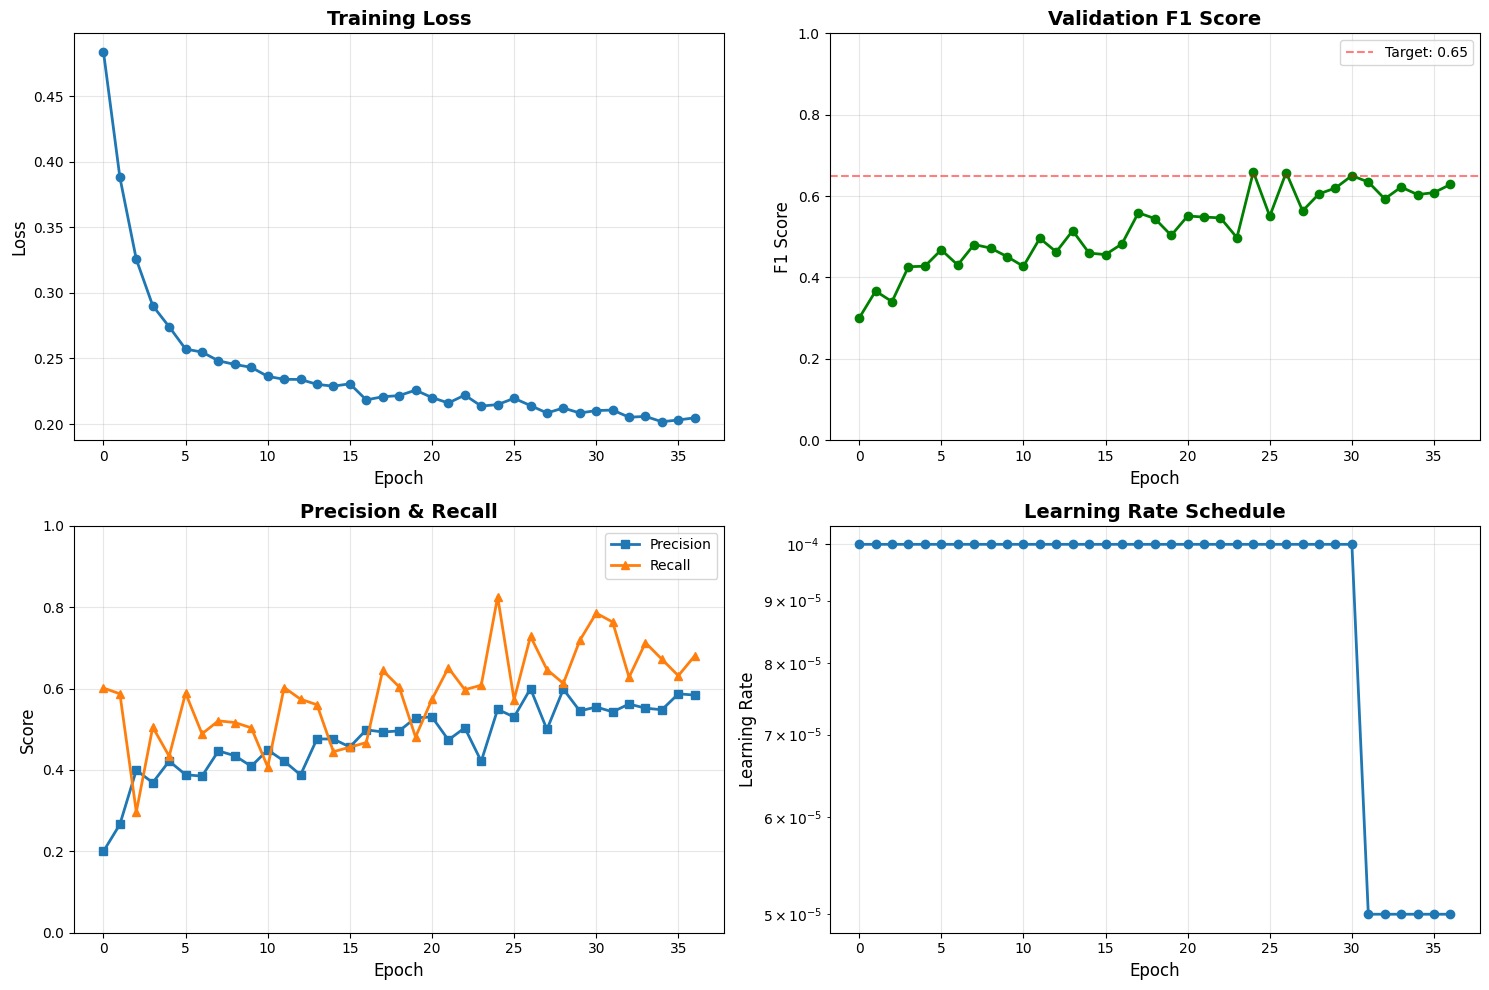

✓ Training plots saved to results/training_history.png


In [27]:
# 3.5 - Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], marker='o', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# F1 Score
axes[0, 1].plot(history['valid_f1'], marker='o', linewidth=2, color='green')
axes[0, 1].axhline(y=0.65, color='red', linestyle='--', alpha=0.5, label='Target: 0.65')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('F1 Score', fontsize=12)
axes[0, 1].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Precision & Recall
axes[1, 0].plot(history['valid_precision'], marker='s', linewidth=2, label='Precision')
axes[1, 0].plot(history['valid_recall'], marker='^', linewidth=2, label='Recall')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Precision & Recall', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Learning Rate
axes[1, 1].plot(history['learning_rate'], marker='o', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plots saved to results/training_history.png")

# 📥 SECTION 4: Download Best Model

Download the trained model to use on your local machine.

In [31]:
# 4.1 - Download best model
from google.colab import files

print("="*80)
print("DOWNLOAD TRAINED MODEL")
print("="*80)

# Show final results
print(f"\nFinal Results:")
print(f"  Best Validation F1: {best_f1:.4f}")
print(f"  Model saved at:     checkpoints/best_model.pth")

print("\nDownloading model...")
files.download('checkpoints/best_model.pth')
print("\n✓ Download started! Check your downloads folder.")

print("\n" + "="*80)

DOWNLOAD TRAINED MODEL

Final Results:
  Best Validation F1: 0.6594
  Model saved at:     checkpoints/best_model.pth



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Download started! Check your downloads folder.

NEXT STEPS
1. Save the downloaded 'best_model.pth' file
2. Use it on your local machine for testing
3. Run predictions on TestData
4. Compare results with previous model

Expected Test F1: 0.65-0.70 (vs previous 0.59)


In [29]:
# 4.2 - Optional: Download training history plot
print("\nDownloading training plots...")
files.download('results/training_history.png')
print("✓ Plot downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Plot downloaded!


# 🎉 Training Complete!

## What You Got:

- ✅ **Attention U-Net** trained on 3,799 images
- ✅ **Optimized for class imbalance** (Tversky Loss)
- ✅ **Best model downloaded** (best_model.pth)
- ✅ **Training history plot**

